In [1]:
from PIL import Image, ImageDraw, ImageOps, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import make_interp_spline
from matplotlib import colors
import os
import io

In [117]:
source = Image.open('input/frog.png')
# source = Image.open('input/moscow.jpg')
secret = Image.open('input/field.jpg')

In [118]:
source_ratio = source.size[0] / source.size[1]
secret_ratio = secret.size[0] / secret.size[1]

if secret_ratio > source_ratio:
    secret = secret.resize((int(source.size[1] * secret_ratio),
                           source.size[1]))
    crop_x = round(secret.size[0] / 2 - source.size[0] / 2)
    secret = secret.crop((crop_x, 
                          0, 
                          crop_x + source.size[0], 
                          secret.size[1]))
else:
    secret = secret.resize((source.size[0], 
                            int(source.size[0] / secret_ratio)))
    crop_y = round(secret.size[1] / 2 - source.size[1] / 2)
    secret = secret.crop((0,
                          crop_y, 
                          secret.size[0], 
                          crop_y + source.size[1]))

In [69]:
# (1080, 1080, 3)

In [74]:
source_np.shape

(1600, 2560, 3)

In [100]:
%%time

source_np = np.array(source)[:,:,:3]
secret_np = np.array(secret)[:,:,:3]

gs = np.array([0.2126, 0.7152, 0.0722])
gs = np.array([0.299, 0.587, 0.114])

for i in range(source_np.shape[0]):
    for j in range(source_np.shape[1]):
        # target = (secret_np[i][j] / 255) @ gs
        target = 0.5
        old_rgb = source_np[i][j] / 255
        delta = gs * (gs @ old_rgb - target) / (gs @ gs)
        new_rgb = old_rgb - delta
        new_rgb = np.clip(new_rgb, 0, 1)
        source_np[i][j] = new_rgb * 255

CPU times: user 17.5 s, sys: 145 ms, total: 17.7 s
Wall time: 18.3 s


In [202]:
source_np = np.array(source)[:,:,:3]
secret_np = np.array(secret)[:,:,:3]

h, w, *_ = source_np.shape

gs = np.array([0.2126, 0.7152, 0.0722])
# gs = np.array([0.299, 0.587, 0.114])

target = 0.5
# target = (secret_np / 255) @ gs

old_rgb = source_np / 255
delta = gs * np.expand_dims(old_rgb @ gs - target, -1) / (gs @ gs)
new_rgb = old_rgb - delta
new_rgb = np.clip(new_rgb, 0, 1) * 255
source_np = new_rgb.astype('uint8')

In [207]:
a = np.random.uniform(size=(3, 1)).T
b = np.random.uniform(size=(3, 1))
(a @ b).shape

(1, 1)

In [337]:
%%time

# gs = [0.2126, 0.7152, 0.0722]
gs = [0.299, 0.587, 0.114]

source_np = np.array(source)[..., :3] / 255
secret_np = np.array(secret)[..., :3] / 255

h, w, _ = source_np.shape

gs = np.reshape(gs, (1, 3))

t = 0.1
# t = secret_np.reshape((h, w, 1, 3)) @ gs.T

colors = source_np.reshape((h, w, 1, 3))
bcs = -gs * (colors @ gs.T - t) / (gs @ gs.T)

ks = np.zeros((h, w, 6, 3))
ks[...] = (np.eye(6, k=-1) + np.eye(6))[..., ::2]

_tmp = np.reshape([0, 1] * 3, (3, 2))
alphas = _tmp - np.moveaxis(colors, -1, -2)
alphas = alphas.reshape((h, w, 6, 1))

matrix = np.zeros((3, 3))
matrix[0, 0] = gs[0, 1] ** 2 + gs[0, 2] ** 2
matrix[1, 1] = gs[0, 0] ** 2 + gs[0, 2] ** 2
matrix[2, 2] = gs[0, 0] ** 2 + gs[0, 1] ** 2
matrix[0, 1] = matrix[1, 0] = -gs[0, 0] * gs[0, 1]
matrix[0, 2] = matrix[2, 0] = -gs[0, 0] * gs[0, 2]
matrix[1, 2] = matrix[2, 1] = -gs[0, 1] * gs[0, 2]

ms = ks @ matrix

ks = ks.reshape((h, w, 6, 1, 3))
ms = ms.reshape((h, w, 6, 3, 1))
bcs = bcs.reshape((h, w, 1, 3, 1))
alphas = alphas.reshape((h, w, 6, 1, 1))

bbcs = ms * (alphas - ks @ bcs) / (ks @ ms) + bcs
bbcs = bbcs.reshape((h, w, 6, 3))

# print(bbcs[i, j]); print()

_c = np.round((colors.repeat(6, axis=2) + bbcs) * 255)
bbcs = np.where((_c < 0) | (_c > 255), 2, bbcs)

# print(bbcs[i, j]); print()

# bbcs = np.nan_to_num(bbcs, nan=2)

# _ds = np.sum((bbcs - bcs.reshape((h, w, 1, 3))) ** 2, axis=-1)
_ds = np.sum(bbcs ** 2, axis=-1)
_min_ds = np.min(_ds, axis=-1)[..., None]
bbcs = (_min_ds == _ds)[..., None] * bbcs
bbcs = bbcs.sum(axis=-2)

# print(bbcs[i, j]); print()

colors = colors.reshape((h, w, 3))
bcs = bcs.reshape((h, w, 3))

nc1 = np.round((colors + bcs) * 255)
nc2 = np.round((colors + bbcs) * 255)

print(np.min(nc1), np.max(nc1))
print(np.min(nc2), np.max(nc2))

# print(nc1[i, j]); print()

_l_lim = np.any(nc1 < 0, axis=-1)
_r_lim = np.any(nc1 > 255, axis=-1)
_condition = (_l_lim | _r_lim)[..., None].repeat(3, -1)
nc = np.where(_condition, nc2, nc1).astype('uint8')

# Image.fromarray((np.clip(color + bc, 0, 1) * 255).reshape((h, w, 3)).astype('uint8')).convert('L')

-53.0 181.0
0.0 758.0
CPU times: user 2.3 s, sys: 894 ms, total: 3.19 s
Wall time: 3.27 s


In [341]:
_1 = np.any(nc1 < 0, axis=-1)
_2 = np.any(nc1 > 255, axis=-1)
_3 = np.any(nc2 < 0, axis=-1)
_4 = np.any(nc2 > 255, axis=-1)
np.any((_1 | _2) & (_3 | _4))

True

In [314]:
for i in range(h):
    for j in range(w):
        val = round((nc[i, j] / 255) @ gs.flatten(), 2)
        if val != t:
            print(f'[{i:>3}, {j:>3}]; val = {val}')

[165, 390]; val = 0.59
[166, 363]; val = 0.54
[166, 364]; val = 0.54
[166, 365]; val = 0.54
[166, 366]; val = 0.55
[166, 367]; val = 0.55
[166, 762]; val = 0.56
[167, 377]; val = 0.55
[167, 762]; val = 0.57
[168, 377]; val = 0.53
[168, 762]; val = 0.54
[169, 378]; val = 0.53
[169, 379]; val = 0.52
[169, 381]; val = 0.54
[169, 762]; val = 0.53
[170, 381]; val = 0.57
[170, 382]; val = 0.57
[170, 383]; val = 0.56
[170, 760]; val = 0.59
[171, 759]; val = 0.58
[171, 760]; val = 0.57
[172, 759]; val = 0.58
[175, 757]; val = 0.59
[175, 759]; val = 0.57
[175, 761]; val = 0.53
[176, 758]; val = 0.56
[176, 759]; val = 0.56
[177, 343]; val = 0.29
[177, 344]; val = 0.26
[177, 391]; val = 0.57
[177, 756]; val = 0.6
[186, 761]; val = 0.23
[187, 760]; val = 0.21
[188, 759]; val = 0.24
[188, 760]; val = 0.24
[190, 758]; val = 0.22
[191, 757]; val = 0.23
[191, 758]; val = 0.22
[196, 722]; val = 0.6
[196, 723]; val = 0.62
[197, 726]; val = 0.65
[198, 726]; val = 0.65
[199, 726]; val = 0.64
[200, 724]; v

In [330]:
colors.repeat(6, axis=2).shape

(1080, 1080, 18)

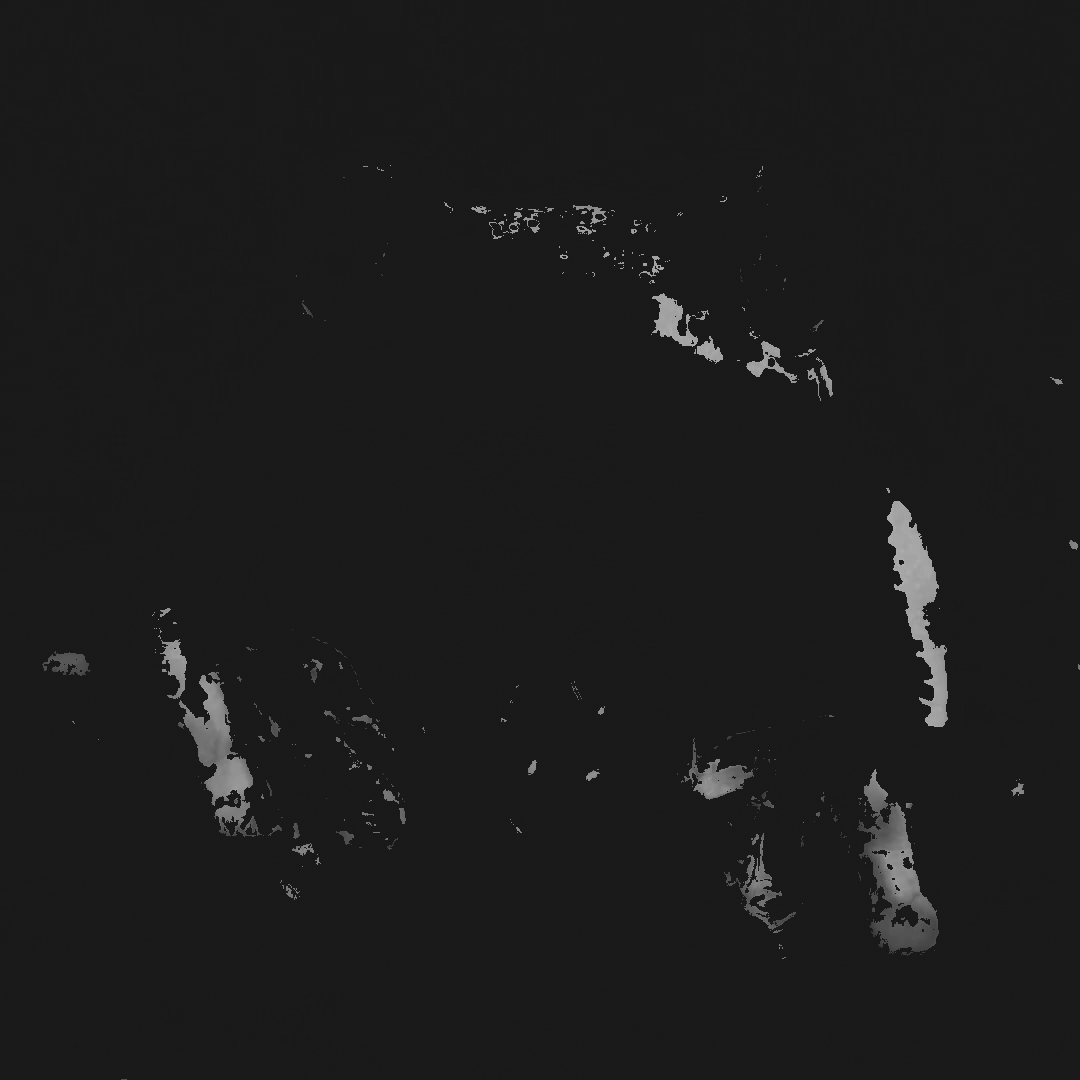

In [321]:
Image.fromarray(nc).convert('L')

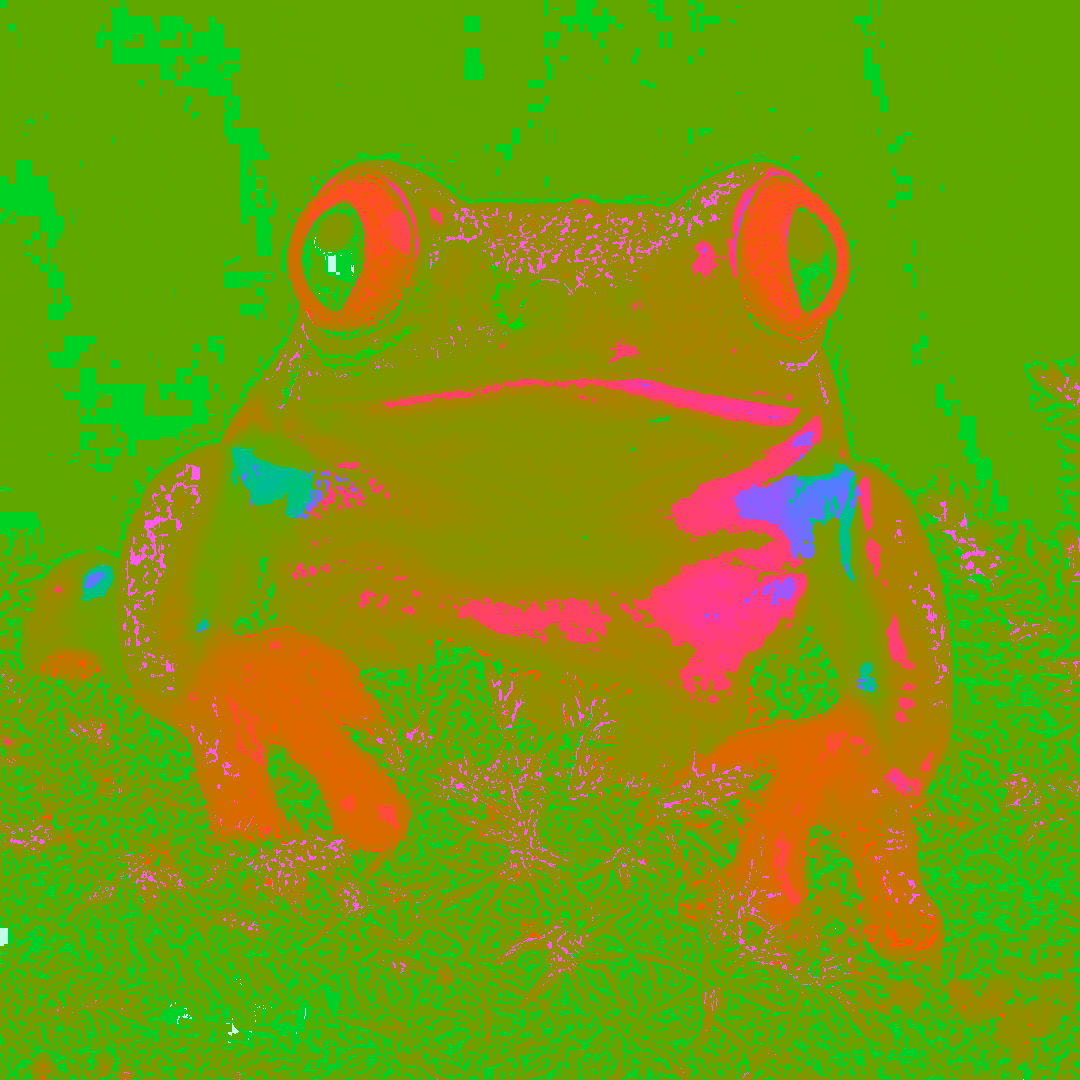

In [255]:
Image.fromarray(((colors + bbcs) * 255).astype('uint8'))#.convert('L')

In [374]:
print('    ms:', ms.shape)
print('alphas:', alphas.shape)
print('    ks:', ks.shape)
print('   bcs:', bcs.shape)

    ms: (1080, 1080, 6, 3, 1)
alphas: (1080, 1080, 6, 1, 1)
    ks: (1080, 1080, 6, 1, 3)
   bcs: (1080, 1080, 1, 3, 1)


In [327]:
bbcs[i, j]

array([-0.42885297,  2.        , -0.11764706])

In [326]:
_c[i, j]

array([[   0.,   44.,   -3.],
       [ 255.,  -81.,  -27.],
       [  89.,    0.,  -11.],
       [-348.,  255., -177.],
       [  87.,   -1.,    0.],
       [  67.,  -40.,  255.]])

In [323]:
nc[i, j]

array([ 87, 212,   0], dtype=uint8)

In [322]:
i, j = [165, 390]

color = colors[i, j].flatten()
k = ks[i, j].reshape(6, 1, 3)
m = ms[i, j].reshape(6, 3, 1)
alpha = alphas[i, j].reshape(6, 1, 1)
bc = bcs[i, j].reshape(3, 1)

dots = (m * (alpha - k @ bc) / (k @ m) + bc).reshape(6, 3)

print('color:', color), print()
print('matrix:\n', matrix, '\n', sep='')
print('k:\n', k.reshape(6, 3), '\n', sep='')
print('m:\n', m.reshape(6, 3), '\n', sep='')
print('alpha:\n', alpha.reshape(6), '\n', sep='')
print('bc:\n', bc.reshape(3), '\n', sep='')
print('dots:\n', dots, '\n', sep='')
# (color + bc) @ gs.flatten()

color: [0.76862745 0.83921569 0.11764706]

matrix:
[[ 0.357565 -0.175513 -0.034086]
 [-0.175513  0.102397 -0.066918]
 [-0.034086 -0.066918  0.43397 ]]

k:
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]

m:
[[ 0.357565 -0.175513 -0.034086]
 [ 0.357565 -0.175513 -0.034086]
 [-0.175513  0.102397 -0.066918]
 [-0.175513  0.102397 -0.066918]
 [-0.034086 -0.066918  0.43397 ]
 [-0.034086 -0.066918  0.43397 ]]

alpha:
[-0.76862745  0.23137255 -0.83921569  0.16078431 -0.11764706  0.88235294]

bc:
[-0.42535549 -0.83506246 -0.16217567]

dots:
[[-0.76862745 -0.66656528 -0.1294522 ]
 [ 0.23137255 -1.15742149 -0.22478032]
 [-0.41823667 -0.83921569 -0.15946147]
 [-2.13228103  0.16078431 -0.81297671]
 [-0.42885297 -0.84192875 -0.11764706]
 [-0.50739757 -0.99612835  0.88235294]]



array([[-0.62745098,  0.13682428,  0.02657235],
       [ 0.37254902, -0.35403193, -0.06875578],
       [ 0.91218742, -0.70980392,  0.34779052],
       [-0.80185694,  0.29019608, -0.30572472],
       [        nan,         nan,         nan],
       [-0.15038035, -0.29522831,  1.        ]])

In [124]:
def get_borders(color):
    r, g, b = color
    return np.array(
        [[ -r,   0,   0], 
         [1-r,   0,   0],
         [  0,  -g,   0],
         [  0, 1-g,   0],
         [  0,   0,  -b],
         [  0,   0, 1-b]]
    )

def get_matrix(grayscale):
    r, g, b = grayscale
    return np.array(
        [[g*g+b*b,    -r*g,    -r*b], 
         [   -r*g, r*r+b*b,    -g*b], 
         [   -r*b,    -g*b, r*r+g*g]]
    )

# color = np.array([0.1, 0.9, 0.1])
# gs = np.array([0.2, 0.3, 0.5])
color = np.array([0.06666667, 0.07843137, 0.0])
gs = np.array([0.299, 0.587, 0.114])
target = 0.5

borders = get_borders(color)
alphas = np.sum(borders, axis=-1)
ks = borders.astype(bool).astype(int)
matrix = get_matrix(gs)
ms = borders @ matrix
bc = -gs * (gs @ color - target) / (gs @ gs)
dots = ms * np.expand_dims(alphas - ks @ bc, -1) / (np.expand_dims(ks, -2) @ np.expand_dims(ms, -1)).reshape((6, 1)) + bc

print('color:', color), print()
print('matrix:\n', matrix, '\n', sep='')
print('k:\n', ks, '\n', sep='')
print('m:\n', ms, '\n', sep='')
print('alpha:\n', alphas, '\n', sep='')
print('bc:\n', bc, '\n', sep='')
print('dots:\n', dots, '\n', sep='')

color: [0.06666667 0.07843137 0.        ]

matrix:
[[ 0.357565 -0.175513 -0.034086]
 [-0.175513  0.102397 -0.066918]
 [-0.034086 -0.066918  0.43397 ]]

k:
[[1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 0 0]
 [0 0 1]]

m:
[[-0.02383767  0.01170087  0.0022724 ]
 [ 0.33372733 -0.16381213 -0.0318136 ]
 [ 0.01376573 -0.00803114  0.00524847]
 [-0.16174727  0.09436586 -0.06166953]
 [ 0.          0.          0.        ]
 [-0.034086   -0.066918    0.43397   ]]

alpha:
[-0.06666667  0.93333333 -0.07843137  0.92156863  0.          1.        ]

bc:
[0.2903447  0.57000782 0.11069998]

dots:
[[-0.06666667  0.74524906  0.14473321]
 [ 0.93333333  0.25439286  0.04940509]
 [ 1.40179823 -0.07843137  0.53446488]
 [-0.31224613  0.92156863 -0.11905036]
 [        nan         nan         nan]
 [ 0.22049498  0.43287811  1.        ]]



/var/folders/5d/m60s_l4s0rxgzhtn791xykqr0000gn/T/ipykernel_58315/3865206412.py:32: RuntimeWarning: invalid value encountered in divide
  dots = ms * np.expand_dims(alphas - ks @ bc, -1) / (np.expand_dims(ks, -2) @ np.expand_dims(ms, -1)).reshape((6, 1)) + bc


In [197]:
np.sum(dots ** 2, axis=-1)

array([0.43470588, 0.90529412, 2.17862069, 0.38551724, 1.30307692,
       0.87230769])

In [155]:
r, g, b = 0.2, 0.3, 0.5
np.dot([0, 0.1, 0], [[g*g+b*b, -r*g, -r*b], [-r*g, r*r+b*b, -g*b], [-r*b, -g*b, r*r+g*g]])

array([-0.006,  0.029, -0.015])